# Data Preprocessing with RoBERTa Embeddings and Feature Engineering

This notebook cell preprocesses textual data by:
1. Extracting **text embeddings** using the `roberta-base` model from HuggingFace's Transformers library.
2. Engineering additional numeric features such as text lengths for each column.
3. Preparing **target labels** for a multi-class classification task based on winner columns.
4. Saving the processed features (`X`) and target labels (`y`) as `.npy` files for training and testing.

### Input Requirements:
- **Train Data (`train.csv`)**:
  - Columns: `prompt`, `response_a`, `response_b`, `winner_model_a`, `winner_model_b`, `winner_tie`
- **Test Data (`test.csv`)**:
  - Columns: `prompt`, `response_a`, `response_b`

### Outputs:
- `X_train.npy`: Combined feature array for training data.
- `y_train.npy`: Target labels for training data.
- `X_test.npy`: Combined feature array for test data.

This process is optimized for batch processing to handle large datasets efficiently and leverages GPU acceleration if available.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

class DataPreprocessor:
    """
    A class for preprocessing text data and extracting features for a machine learning model.
    It includes methods to tokenize and extract embeddings from text using a pre-trained transformer model
    (RoBERTa), as well as for feature engineering and preparing target labels.

    Attributes:
        device (torch.device): The device to run computations on ('cuda' if available, otherwise 'cpu').
        tokenizer (AutoTokenizer): A tokenizer for tokenizing input text, initialized from 'roberta-base'.
        embedding_model (AutoModel): A pre-trained transformer model for extracting text embeddings, initialized from 'roberta-base'.
    """

    def __init__(self):
        """
        Initializes the DataPreprocessor class by setting the computation device (CPU/GPU) and loading
        the tokenizer and transformer model (RoBERTa).
        """
        # Set the computation device to GPU if available, otherwise use CPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load RoBERTa tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')

        # Load RoBERTa model and move it to the computation device
        self.embedding_model = AutoModel.from_pretrained('roberta-base').to(self.device)

    def extract_embeddings(self, texts, batch_size=16):
        """
        Extracts text embeddings using the RoBERTa model. The embeddings are taken from the [CLS] token 
        (first token of the last hidden state).

        Args:
            texts (pd.Series or list): A list or pandas Series of strings (text data).
            batch_size (int): The batch size to use for processing text inputs.

        Returns:
            np.ndarray: A NumPy array of shape (len(texts), embedding_size) containing the embeddings for the input texts.
        """
        all_embeddings = []  # List to store embeddings for all text batches

        # Process texts in batches to handle memory efficiently
        for i in range(0, len(texts), batch_size):
            # Extract a batch of texts
            batch = texts[i:i + batch_size].tolist()

            # Tokenize the batch (convert text to token IDs) and move to the computation device
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512).to(self.device)

            # Use the model to compute embeddings, disabling gradient computation for efficiency
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)

            # Extract embeddings from the [CLS] token (first token) of the last hidden state
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            # Append the batch embeddings to the list
            all_embeddings.append(embeddings)

        # Concatenate all batch embeddings into a single NumPy array
        return np.concatenate(all_embeddings)

    def feature_engineering(self, df):
        """
        Performs feature engineering on the input DataFrame by extracting text embeddings and other numeric features.

        Args:
            df (pd.DataFrame): A pandas DataFrame containing 'prompt', 'response_a', and 'response_b' columns.

        Returns:
            np.ndarray: A NumPy array of shape (len(df), feature_size) containing engineered features.
        """
        # Add simple numeric features: the lengths of the prompt and responses
        df['prompt_length'] = df['prompt'].str.len()
        df['response_a_length'] = df['response_a'].str.len()
        df['response_b_length'] = df['response_b'].str.len()

        # Extract text embeddings for prompts and responses
        df['prompt_embedding'] = list(self.extract_embeddings(df['prompt']))
        df['response_a_embedding'] = list(self.extract_embeddings(df['response_a']))
        df['response_b_embedding'] = list(self.extract_embeddings(df['response_b']))

        # Combine embeddings into a single feature array
        embeddings = np.hstack([
            np.vstack(df['prompt_embedding']),       # Prompt embeddings
            np.vstack(df['response_a_embedding']),   # Response A embeddings
            np.vstack(df['response_b_embedding'])    # Response B embeddings
        ])

        # Combine embeddings with numeric features
        numeric_features = df[['prompt_length', 'response_a_length', 'response_b_length']].values
        X = np.hstack([embeddings, numeric_features])

        return X

    def prepare_target(self, df):
        """
        Prepares the target variable for classification. Converts the winner columns into a single integer label:
        0 for 'winner_model_a', 1 for 'winner_model_b', and 2 for 'winner_tie'.

        Args:
            df (pd.DataFrame): A pandas DataFrame containing 'winner_model_a', 'winner_model_b', and 'winner_tie' columns.

        Returns:
            np.ndarray: A NumPy array of shape (len(df),) containing integer labels.
        """
        # Initialize target array with zeros
        target = np.zeros(len(df))

        # Set target labels based on winner columns
        target[df['winner_model_a'] == 1] = 0
        target[df['winner_model_b'] == 1] = 1
        target[df['winner_tie'] == 1] = 2

        return target

    def preprocess_and_save(self, train_path, test_path):
        """
        Preprocesses training and test data by extracting features and targets, then saves them as NumPy arrays.

        Args:
            train_path (str): Path to the training CSV file.
            test_path (str): Path to the test CSV file.
        """
        # Load training and test datasets
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Preprocess and save training data
        print("Processing training data...")
        X_train = self.feature_engineering(train_df)  # Extract features
        np.save('X_train.npy', X_train)              # Save features as a NumPy array
        y_train = self.prepare_target(train_df)      # Prepare target labels
        np.save('y_train.npy', y_train)              # Save target labels as a NumPy array

        # Preprocess and save test data
        print("Processing test data...")
        X_test = self.feature_engineering(test_df)   # Extract features
        np.save('X_test.npy', X_test)                # Save features as a NumPy array

        print("Data preprocessing complete. NumPy arrays saved.")

if __name__ == '__main__':
    # Create an instance of the DataPreprocessor
    preprocessor = DataPreprocessor()

    # Preprocess and save the data
    preprocessor.preprocess_and_save('sample_data/train.csv', 'sample_data/test.csv')


## FullDatasetLLMPredictor: Training LLM Preference Prediction Model

This cell contains a Python script to train a LightGBM model on the entire training dataset for the **LLM Model Preference Prediction** task. It uses preprocessed feature matrices and labels, trains a multiclass classifier, evaluates its performance, and generates predictions for the test dataset.

### Key Highlights:
1. **LightGBM Classifier**:
   - Multiclass classification objective (`winner_model_a`, `winner_model_b`, `winner_tie`).
   - Random seed ensures reproducibility.

2. **Training on Full Dataset**:
   - Utilizes the entire training data for training without splitting.
   - Provides detailed evaluation metrics (accuracy, precision, recall, F1-score) on the training data.

3. **Test Predictions**:
   - Generates class probabilities for test samples.
   - Saves the predictions in a `submission.csv` file for easy submission.

4. **Saved Model**:
   - The trained LightGBM model is saved as a text file (`Trained_Model3_Full.txt`) for future use.

### Outputs:
- Training Accuracy: Performance of the model on the training data.
- Classification Report: Precision, recall, F1-score, and support for each class.
- Saved Model: Stored as `Trained_Model3_Full.txt`.
- Submission File: Test predictions saved as `submission.csv`.

> **Instructions**: Run this cell after preprocessing the dataset to train the model and generate predictions.


In [2]:
import numpy as np  # For numerical operations and loading preprocessed data
import pandas as pd  # For creating the submission DataFrame

class FullDatasetLLMPredictor:
    """
    A class to train and evaluate a LightGBM model on the entire dataset 
    for predicting the preference between LLM responses.

    Attributes:
        accuracy (float): The accuracy score of the model on the training dataset.
        detailed_metrics (dict): Detailed classification metrics, including precision, recall, and F1-score.
    """

    def __init__(self):
        """
        Initializes the predictor with attributes to store accuracy and detailed metrics.
        """
        self.accuracy = None  # Placeholder for accuracy score
        self.detailed_metrics = None  # Placeholder for detailed classification metrics

    def train_model(self, X_train, y_train):
        """
        Trains a LightGBM model on the provided training data.

        Args:
            X_train (numpy.ndarray): Feature matrix for training.
            y_train (numpy.ndarray): Labels corresponding to the training features.

        Returns:
            lgb.LGBMClassifier: Trained LightGBM model.
        """
        # Initialize the LightGBM classifier with multiclass support
        model = lgb.LGBMClassifier(
            objective='multiclass',  # Specifies a multiclass classification objective
            num_class=3,  # Number of target classes (Model A, Model B, Tie)
            random_state=42  # Set random seed for reproducibility
        )

        # Train the model on the entire training dataset
        model.fit(X_train, y_train)

        # Make predictions on the training data for evaluation
        train_pred = model.predict(X_train)

        # Calculate accuracy on the training data
        self.accuracy = accuracy_score(y_train, train_pred)

        # Generate a detailed classification report
        self.detailed_metrics = classification_report(y_train, train_pred, output_dict=True)

        # Print results for transparency
        print(f"Training Accuracy: {self.accuracy:.4f}")
        print("Detailed Classification Report:")
        print(classification_report(y_train, train_pred))  # Human-readable report

        return model  # Return the trained model

if __name__ == '__main__':
    # Load preprocessed feature matrices and labels
    X_train = np.load('X_train3.npy')  # Load training feature data
    y_train = np.load('y_train3.npy')  # Load training label data
    X_test = np.load('X_test3.npy')  # Load test feature data

    # Initialize the predictor class
    predictor = FullDatasetLLMPredictor()

    # Train the model on the entire dataset
    model = predictor.train_model(X_train, y_train)

    # Save the trained LightGBM model to a file for future use
    model.booster_.save_model('Trained_Model.txt')  # Save as a text file
    print("Model saved as 'Trained_Model.txt'")

    # Generate predictions for the test dataset
    test_probs = model.predict_proba(X_test)  # Probability predictions for each class

    # Prepare a submission DataFrame with probabilities for each class
    submission = pd.DataFrame({
        'id': test_probs,  # Unique identifier for each test sample
        'winner_model_a': test_probs[:, 0],  # Probability of Model A being the winner
        'winner_model_b': test_probs[:, 1],  # Probability of Model B being the winner
        'winner_tie': test_probs[:, 2]      # Probability of a tie
    })

    # Save the submission DataFrame as a CSV file
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved.")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.752340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588285
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 2307
[LightGBM] [Info] Start training from score -1.052039
[LightGBM] [Info] Start training from score -1.067768
[LightGBM] [Info] Start training from score -1.180908
Training Accuracy: 0.7702
Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78     13969
         1.0       0.76      0.80      0.78     13751
         2.0       0.82      0.68      0.74     12280

    accuracy                           0.77     40000
   macro avg       0.78      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000

Model saved as 'Trained_Model.txt'
Submission file saved.


Accuracy on Validation Data: 74.79%
RMSE on Validation Data: 0.3941
Log Loss on Validation Data: 0.8116

Classification Report:
              precision    recall  f1-score   support

     Model A       0.72      0.79      0.75      2794
     Model B       0.75      0.78      0.76      2750
         Tie       0.79      0.66      0.72      2456

    accuracy                           0.75      8000
   macro avg       0.75      0.74      0.75      8000
weighted avg       0.75      0.75      0.75      8000


Confusion Matrix:
[[2215  342  237]
 [ 409 2135  206]
 [ 453  370 1633]]


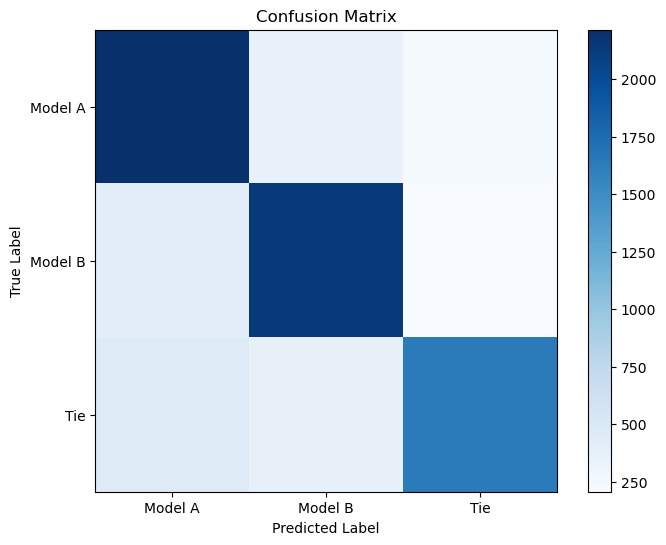

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load data
X_train = np.load('X_train3.npy')  # Features
y_train = np.load('y_train3.npy')  # True labels

# Ensure y_train is of integer type
y_train = y_train.astype(int)

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Load the trained model
model = lgb.Booster(model_file='Trained_Model3.txt')

# Predict probabilities on the validation set
val_probs = model.predict(X_val_split)

# Convert probabilities to predicted classes
val_preds = np.argmax(val_probs, axis=1)

# Accuracy
accuracy = accuracy_score(y_val_split, val_preds)
print(f"Accuracy on Validation Data: {accuracy * 100:.2f}%")

# RMSE
# Prepare one-hot-encoded true labels for RMSE calculation
y_val_one_hot = np.zeros_like(val_probs)
y_val_one_hot[np.arange(len(y_val_split)), y_val_split] = 1  # One-hot encoding
rmse = np.sqrt(mean_squared_error(y_val_one_hot, val_probs))
print(f"RMSE on Validation Data: {rmse:.4f}")

# Log Loss
logloss = log_loss(y_val_split, val_probs)
print(f"Log Loss on Validation Data: {logloss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_split, val_preds, target_names=["Model A", "Model B", "Tie"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_split, val_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.yticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.show()